## Exploring augmentation with horses vs. humans

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2021-02-10 19:44:51--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 34.64.4.80, 34.64.4.16
Connecting to storage.googleapis.com (storage.googleapis.com)|34.64.4.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  7.79MB/s    in 17s     

2021-02-10 19:45:08 (8.51 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2021-02-10 19:45:08--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 34.64.4.80, 34.64.4.16
Connecting to storage.googleapis.com (storage.googleapis.com)|34.64.4.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘/tmp/validation-horse-o

In [2]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

### Building a Small Model from Scratch
But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

In [3]:
import tensorflow as tf

We then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

Finally we add the densely connected layers.

Note that because we are facing a two-class classification problem, i.e. a binary classification problem, we will end our network with a sigmoid activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [4]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [5]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [7]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=100,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/100
8/8 [==============================] - 30s 4s/step - loss: 0.6909 - accuracy: 0.5239 - val_loss: 0.6804 - val_accuracy: 0.5352
Epoch 2/100
8/8 [==============================] - 30s 4s/step - loss: 0.6782 - accuracy: 0.6118 - val_loss: 0.6591 - val_accuracy: 0.5508
Epoch 3/100
8/8 [==============================] - 28s 4s/step - loss: 0.6439 - accuracy: 0.7430 - val_loss: 0.5914 - val_accuracy: 0.5508
Epoch 4/100
8/8 [==============================] - 30s 4s/step - loss: 0.6074 - accuracy: 0.7075 - val_loss: 0.6263 - val_accuracy: 0.6250
Epoch 5/100
8/8 [==============================] - 30s 4s/step - loss: 0.5548 - accuracy: 0.7442 - val_loss: 0.7559 - val_accuracy: 0.5898
Epoch 6/100
8/8 [==============================] - 30s 4s/step - loss: 0.5259 - accuracy: 0.7620 - val_loss: 1.1462 - val_accuracy: 0.5352
Epoch 7/100
8/8 [==============================] - 30s 4s/step - loss: 0.4969 - accuracy: 0.7597 - val_loss: 1.0794 - val_accuracy: 0.5859
Epoch 8/100
8/8 [==========

8/8 [==============================] - 30s 4s/step - loss: 0.1939 - accuracy: 0.9255 - val_loss: 2.9608 - val_accuracy: 0.6562
Epoch 60/100
8/8 [==============================] - 30s 4s/step - loss: 0.2412 - accuracy: 0.9066 - val_loss: 2.8146 - val_accuracy: 0.6562
Epoch 61/100
8/8 [==============================] - 30s 4s/step - loss: 0.1544 - accuracy: 0.9399 - val_loss: 3.4317 - val_accuracy: 0.6406
Epoch 62/100
8/8 [==============================] - 29s 4s/step - loss: 0.2050 - accuracy: 0.9143 - val_loss: 3.2750 - val_accuracy: 0.6289
Epoch 63/100
8/8 [==============================] - 30s 4s/step - loss: 0.1809 - accuracy: 0.9255 - val_loss: 2.7243 - val_accuracy: 0.6562
Epoch 64/100
8/8 [==============================] - 31s 4s/step - loss: 0.1544 - accuracy: 0.9388 - val_loss: 2.8150 - val_accuracy: 0.6641
Epoch 65/100
8/8 [==============================] - 29s 4s/step - loss: 0.2794 - accuracy: 0.8943 - val_loss: 2.5299 - val_accuracy: 0.6641
Epoch 66/100
8/8 [===============

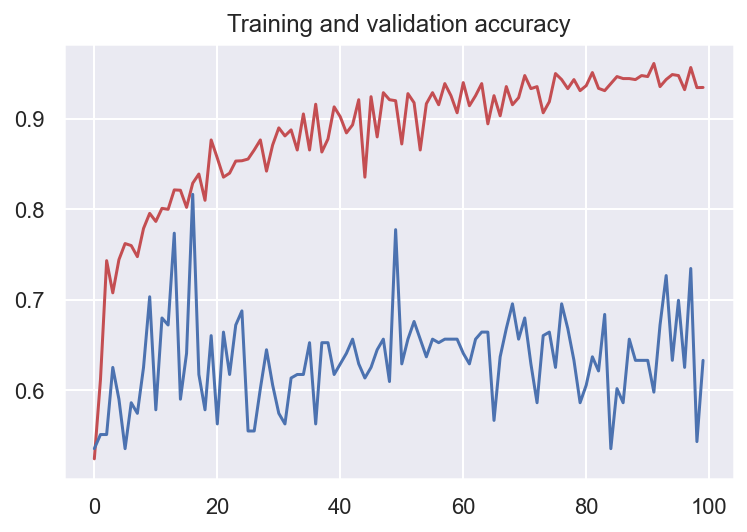

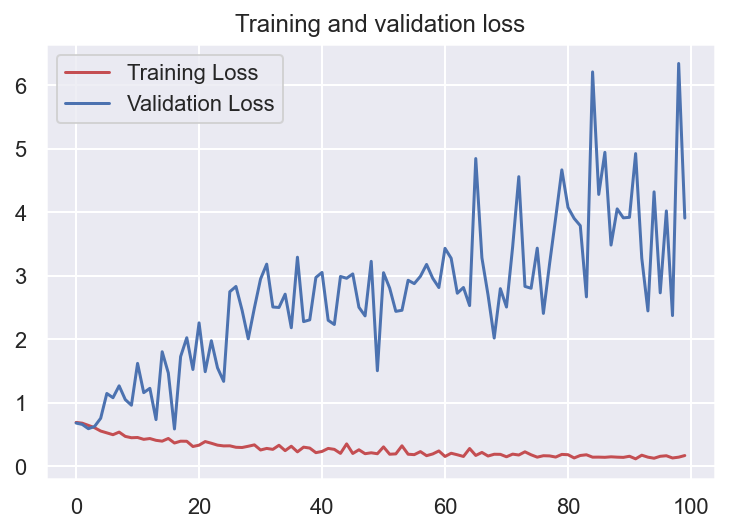

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()